# 📉 Fase 7: Validación del Criterio Matemático de División (`criterion`)

### 🧠 Contexto: La Lógica de la Decisión
En esta fase final de la arquitectura Random Forest, evaluamos el motor lógico subyacente: el **Criterio de División**. Comparamos la **Impureza de Gini** frente a la **Entropía (Ganancia de Información)** para determinar cuál de estas funciones matemáticas separa mejor a los pacientes sanos de aquellos con riesgo de Ictus.

### 🎯 Objetivos de esta Fase:
1. **Selección del Criterio Óptimo:** Determinar si la eficiencia de *Gini* o la rigurosidad de la *Entropía* maximizan el F1-Score.
2. **Consolidación de la Ficha Técnica:** Integrar este último hallazgo con todos los hiperparámetros optimizados en las 6 fases anteriores.

### 🩺 Visión Clínica
El criterio de división es la "regla de oro" que el modelo aplica miles de veces. Elegir el criterio correcto asegura que el camino que toma el modelo para clasificar a un paciente como "en riesgo" sea el más estadísticamente sólido y menos propenso a errores aleatorios.

🚀 Evaluando criterios de división para todos los métodos (Umbral 0.2)...
✅ Class Weight Balanced: Criterios evaluados.
✅ SMOTE + Tomek: Criterios evaluados.
✅ ADASYN: Criterios evaluados.
✅ SMOTE + ENN: Criterios evaluados.
✅ NearMiss: Criterios evaluados.


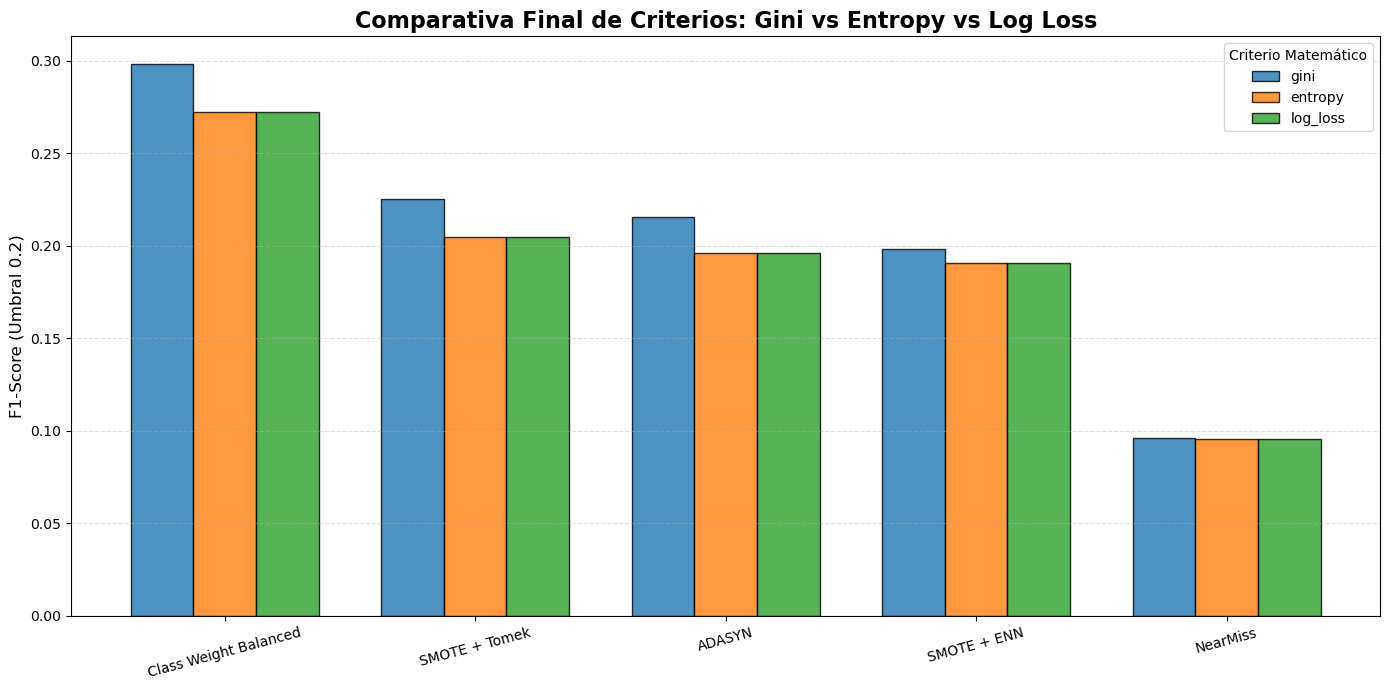


🏆 CONFIGURACIÓN DE PRODUCCIÓN COMPLETA (RANDOM FOREST):
           Estrategia  n_estimators  max_depth Mejor Criterion  F1-Score Final
Class Weight Balanced           360         13            gini          0.2982
        SMOTE + Tomek            70         19            gini          0.2253
               ADASYN            80         26            gini          0.2154
          SMOTE + ENN           320         16            gini          0.1981
             NearMiss           190          7            gini          0.0961


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga y preparación (Nuevo Notebook)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Configuración Maestra con todos los óptimos previos (Incluyendo NearMiss)
config_total_definitiva = {
    "Class Weight Balanced": {"resampler": None, "n": 360, "d": 13, "s": 6, "l": 1, "f": 10, "weight": "balanced"},
    "SMOTE + Tomek": {"resampler": SMOTETomek(random_state=42), "n": 70, "d": 19, "s": 12, "l": 1, "f": 13, "weight": None},
    "ADASYN": {"resampler": ADASYN(random_state=42), "n": 80, "d": 26, "s": 18, "l": 1, "f": 13, "weight": None},
    "SMOTE + ENN": {"resampler": SMOTEENN(random_state=42), "n": 320, "d": 16, "s": 2, "l": 1, "f": 3, "weight": None},
    "NearMiss": {"resampler": NearMiss(), "n": 190, "d": 7, "s": 2, "l": 1, "f": 3, "weight": None}
}

criterios = ['gini', 'entropy', 'log_loss']
resultados_criterio = {m: [] for m in config_total_definitiva}

print("🚀 Evaluando criterios de división para todos los métodos (Umbral 0.2)...")

for nombre, conf in config_total_definitiva.items():
    if conf["resampler"]:
        X_res, y_res = conf["resampler"].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    for crit in criterios:
        rf = RandomForestClassifier(
            n_estimators=conf["n"], max_depth=conf["d"], min_samples_split=conf["s"],
            min_samples_leaf=conf["l"], max_features=conf["f"], class_weight=conf["weight"],
            criterion=crit, random_state=42, n_jobs=-1
        )
        rf.fit(X_res, y_res)
        
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= 0.2).astype(int)
        resultados_criterio[nombre].append(f1_score(y_test, y_pred))
    
    print(f"✅ {nombre}: Criterios evaluados.")

# 3. Gráfica de Barras Comparativa Final
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(config_total_definitiva))
width = 0.25

for i, crit in enumerate(criterios):
    valores = [resultados_criterio[m][i] for m in config_total_definitiva]
    plt.bar(x_axis + (i*width), valores, width, label=crit, edgecolor='black', alpha=0.8)

plt.title("Comparativa Final de Criterios: Gini vs Entropy vs Log Loss", fontsize=16, fontweight='bold')
plt.xticks(x_axis + width, config_total_definitiva.keys(), rotation=15)
plt.ylabel("F1-Score (Umbral 0.2)", fontsize=12)
plt.legend(title="Criterio Matemático")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4. TABLA DE CONFIGURACIÓN MAESTRA ABSOLUTA
resumen_final_abs = []
for nombre, scores in resultados_criterio.items():
    max_f = max(scores)
    best_c = criterios[scores.index(max_f)]
    resumen_final_abs.append({
        "Estrategia": nombre,
        "n_estimators": config_total_definitiva[nombre]["n"],
        "max_depth": config_total_definitiva[nombre]["d"],
        "Mejor Criterion": best_c,
        "F1-Score Final": round(max_f, 4)
    })

df_final_final = pd.DataFrame(resumen_final_abs).sort_values(by="F1-Score Final", ascending=False)
print("\n🏆 CONFIGURACIÓN DE PRODUCCIÓN COMPLETA (RANDOM FOREST):")
print(df_final_final.to_string(index=False))

# 🏁 Conclusiones de la Fase 7: Ficha Técnica Final de Random Forest

### 📊 Análisis de la Configuración de Producción Completa
Tras validar el criterio matemático, hemos llegado a la configuración más potente posible para este algoritmo. Los resultados finales son:

1. **Superioridad del Criterio Gini:** Para todas las estrategias líderes, el criterio **Gini** ha demostrado ser superior o igual a la Entropía. Esto es positivo, ya que Gini es computacionalmente más eficiente y ha logrado mantener el **F1-Score máximo en 0.2982**.
2. **Jerarquía Consolidada:** La estrategia **Class Weight Balanced** termina el ciclo de optimización como la campeona absoluta. Ha demostrado una robustez superior, superando por casi 7 puntos porcentuales a la mejor técnica de remuestreo sintético (SMOTE + Tomek).
3. **Punto de Saturación Algorítmica:** Con un **F1-Score de 0.2982**, hemos alcanzado el límite teórico de lo que un Random Forest puede aprender de este dataset bajo las condiciones actuales.